# Project: ICD-AIS conversion using Deep Learning

### This script creates sparse matrices for the input and output files and creates a neural net using that data

## Setup

In [35]:
import pandas as pd
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import math
import time

import modules.helper_functions_800 as hlp

In [36]:
ais_train_file = "../Data/train_ais_agecat_I9_A05.csv"
icd_train_file ="../Data/train_icd_agecat_I9_A05.csv"
ais_val_file = "../Data/val_ais_agecat_I9_A05.csv"
icd_val_file ="../Data/val_icd_agecat_I9_A05.csv"
ais_test_file = "../Data/test_ais_agecat_I9_A05.csv"
icd_test_file ="../Data/test_icd_agecat_I9_A05.csv"
ais_codes_file = "../Data/AIS08_codes.csv"

### Changing the below line means you MUST [create sparse matrices](#create_sparse) 

In [3]:
# Decide on a batch size for training neural net
# This is up here to create an array of spliced sparse matrices based on batch size
batch_size = 1000 

In [4]:
icd_train = pd.read_csv(icd_train_file, header=None, names=["icd_code"])
icd_val = pd.read_csv(icd_val_file, header=None, names=["icd_code"])
icd_test = pd.read_csv(icd_test_file, header=None, names=["icd_code"])
ais_train = pd.read_csv(ais_train_file, header=None, names=["icd_code"])
ais_val = pd.read_csv(ais_val_file, header=None, names=["icd_code"])
ais_test = pd.read_csv(ais_test_file, header=None, names=["icd_code"])

# load AIS codes
ais_map = pd.read_csv(ais_codes_file, header=0, encoding='iso-8859-1')

## Retrieve all data to train the neural net

### Only use this if you want to skip to [creating a neural net](#neural_net) with a new kernel as opposed to running the whole notebook again.

In [5]:
%store -r icd_codes
icd_dict = dict(zip(icd_codes, list(range(len(icd_codes)))))

%store -r ais_codes
ais_dict = dict(zip(ais_codes, list(range(len(ais_codes)))))

%store -r sparse_icd_train
%store -r sparse_icd_test
%store -r sparse_icd_val

%store -r sparse_ais_train
%store -r sparse_ais_test
%store -r sparse_ais_val

%store -r spliced_icd_train
%store -r spliced_icd_test
%store -r spliced_icd_val

%store -r spliced_ais_train
%store -r spliced_ais_test
%store -r spliced_ais_val

## Extract all unique patient ICD and AIS codes

In [85]:
%%time
# get unique icd codes from all sets
icd_codes = hlp.get_unique_codes([icd_train, icd_val, icd_test])
%store icd_codes

KeyboardInterrupt: 

In [115]:
# create dictionary of ICD codes
icd_dict = dict(zip(icd_codes, list(range(len(icd_codes)))))

In [116]:
%%time
# get unique ais codes from all sets
ais_codes = hlp.get_unique_codes([ais_train, ais_val, ais_test])
%store ais_codes

KeyboardInterrupt: 

In [8]:
# create dictionary of AIS codes
ais_dict = dict(zip(ais_codes, list(range(len(ais_codes)))))

<a id='create_sparse'></a>
## Create sparse matrices

Run the three below lines when changing batch size

In [6]:
# Batch size is the NUMBER OF PATIENTS we are analyzing at once
def get_list_of_spliced_matrices(row, col, data, pt_num, dic):
    # Start at row 0
    current_row = 0
    end = 0
    #print("Length of rows " + str(len(row)))
    #print("Total pt number " + str(pt_num))
    #print("Batch size " + str(batch_size))
    # If pt_num is < batch size then 1 is the num_sparse_matrices, otherwise divy up into batches (sparse matrices)
    if batch_size < pt_num:
        # So if batch size >= pt_num then divide pt_num by batch size, that's the number of sparse matrices
        num_sparse_matrices = int(math.ceil(pt_num/(batch_size)))
    else:
        num_sparse_matrices = 1
        
    # Now go thru the determined number of sparse matrices and add batches of matrices
    sparse_batch_list = []
    for i in range(0, num_sparse_matrices):
        #print(row[current_row])
        #print("Current row " + str(current_row))
        current_pt = row[current_row]
        # If we add batch_size to current row and we are below pt_num then good, lets keep going
        #print("On matrix " + str(i+1) + "/" + str(num_sparse_matrices), end="\r")
        # Now lets add a smaller sparse coo tensor to the batch list
        rows = []
        cols = []
        datas = []
        last_pt = 0
        if (current_pt + batch_size) < pt_num:
            end = row.index((current_pt + batch_size))
            #print("We aren't at end...")
            #print("Current Patient " + str(current_pt))
            #print("End " + str(end))
            
        # Else end is pt_num
        else:
            end = row.index(pt_num-1)+1
            #print("Current Patient " + str(current_pt))
            #print("End " + str(end))
            
        
        while current_row < end:
            subtractor = ((batch_size*i))
            #print("SUBTRACTOR " + str(subtractor))
            rows.append((row[current_row] - subtractor))
            last_pt = (row[current_row] - subtractor)
            cols.append(col[current_row])
            datas.append(data[current_row])
            current_row += 1
            
        missing_codes = list(map(int, hlp.find_missing(cols, dic)))
        cols.extend(missing_codes)
        #print("Missing codes length: " + str(len(missing_codes)))
        for i in range(len(missing_codes)):
            rows.append(last_pt)
            datas.append(0)
            
        #print("ROWS LENGTH " + str(len(rows)))
        tmp_tensor = torch.sparse_coo_tensor([rows,cols], 
                                datas, 
                                dtype=torch.float)
        
        l = 1
        if len(rows) != batch_size:
            rows.append(last_pt + l)
            cols.append(0)
            datas.append(0)
        sparse_batch_list.append(tmp_tensor.detach().clone())
        del rows
        del cols
        del datas
        del tmp_tensor
            
    return sparse_batch_list

### Create training, testing, and validation ICD matrices

In [7]:
%%time

print('Creating training matrices...')
row, col, data = hlp.decode_df_coo(icd_train, icd_dict)
print("Number patients " + str(len(icd_train)))
#sparse_icd_train = torch.sparse_coo_tensor([row,col], data, dtype=torch.float)
spliced_icd_train = get_list_of_spliced_matrices(row, col, data, len(icd_train), icd_dict)
length = 0
for mat in spliced_icd_train:
    length += len(mat)
print("Length of all sparse matrices together: " + str(length))

print('\nCreating testing matrices...')
row, col, data = hlp.decode_df_coo(icd_test, icd_dict)
print("Number patients " + str(len(icd_test)))
#sparse_icd_test = torch.sparse_coo_tensor([row,col], data, dtype=torch.float)
spliced_icd_test = get_list_of_spliced_matrices(row, col, data, len(icd_test), icd_dict)
length = 0
for mat in spliced_icd_test:
    length += len(mat)
print("Length of all sparse matrices together: " + str(length))

print('\nCreating validation matrices...')
row, col, data = hlp.decode_df_coo(icd_val, icd_dict)
print("Number patients " + str(len(icd_val)))
#sparse_icd_val = torch.sparse_coo_tensor([row,col], data, dtype=torch.float)
spliced_icd_val = get_list_of_spliced_matrices(row, col, data, len(icd_val), icd_dict)
print("Length of all sparse matrices together: " +  str(len(spliced_icd_val[0])))



%store sparse_icd_train
%store sparse_icd_test
%store sparse_icd_val
%store spliced_icd_train
%store spliced_icd_test
%store spliced_icd_val

Creating training matrices...
Missing codes length: 155
Number patients 895455
Length of all sparse matrices together: 895455

Creating testing matrices...
Missing codes length: 3483
Number patients 99717
Length of all sparse matrices together: 99717

Creating validation matrices...
Missing codes length: 7776
Number patients 2000
Length of all sparse matrices together: 1000
Stored 'sparse_icd_train' (Tensor)
Stored 'sparse_icd_test' (Tensor)
Stored 'sparse_icd_val' (Tensor)
Stored 'spliced_icd_train' (list)
Stored 'spliced_icd_test' (list)
Stored 'spliced_icd_val' (list)
CPU times: user 8min 32s, sys: 23.6 s, total: 8min 56s
Wall time: 5min 45s


### Create training, testing, and validation AIS matrices

In [8]:

row, col, data = hlp.decode_df_coo(ais_train, ais_dict)
print('Creating training matrices...')
#sparse_ais_train = torch.sparse_coo_tensor([row,col], data, dtype=torch.float)
print("Number patients " + str(len(ais_train)))
spliced_ais_train = get_list_of_spliced_matrices(row, col, data, len(ais_train), ais_dict)
length = 0
for mat in spliced_ais_train:
    length += len(mat)
print("Length of all sparse matrices together: " + str(length))

print("\nCreating testing matrices...")
row, col, data = hlp.decode_df_coo(ais_test, ais_dict)
#sparse_ais_test = torch.sparse_coo_tensor([row,col], data, dtype=torch.float)
print("Number patients " + str(len(ais_test)))
spliced_ais_test = get_list_of_spliced_matrices(row, col, data, len(ais_test), ais_dict)
length = 0
for mat in spliced_ais_test:
    length += len(mat)
print("Length of all sparse matrices together: " + str(length))

print("\nCreating validation matrices...")
row, col, data = hlp.decode_df_coo(ais_val, ais_dict)
print("Number patients " + str(len(ais_val)))
#sparse_ais_val = torch.sparse_coo_tensor([row,col], data, dtype=torch.float)
spliced_ais_val = get_list_of_spliced_matrices(row, col, data, len(ais_val), ais_dict)
print("Length of all sparse matrices together: " +  str(len(spliced_ais_val[0])))


%store sparse_ais_train
%store sparse_ais_test
%store sparse_ais_val
%store spliced_ais_train
%store spliced_ais_test
%store spliced_ais_val

Missing codes length: 0
Creating training matrices...
Number patients 895455
Length of all sparse matrices together: 895455

Creating testing matrices...
Missing codes length: 111
Number patients 99717
Length of all sparse matrices together: 99717

Creating validation matrices...
Missing codes length: 1118
Number patients 2000
Length of all sparse matrices together: 1000
Stored 'sparse_ais_train' (Tensor)
Stored 'sparse_ais_test' (Tensor)
Stored 'sparse_ais_val' (Tensor)
Stored 'spliced_ais_train' (list)
Stored 'spliced_ais_test' (list)
Stored 'spliced_ais_val' (list)


## Test validity of create sparse matrices

In [6]:
%%time

# Create inverted dicts to test validity
icd_inverted_dict = {v: k for k, v in icd_dict.items()}
ais_inverted_dict = {v: k for k, v in ais_dict.items()}

CPU times: user 600 µs, sys: 0 ns, total: 600 µs
Wall time: 605 µs


In [ ]:
%%time
ne, matrix_df = hlp.test_sparse_matrix(sparse_icd_train, icd_train, icd_inverted_dict)
hlp.print_diff(ne)

In [7]:
%%time
ne, matrix_df = hlp.test_sparse_matrices(spliced_icd_test, icd_test, icd_inverted_dict)
hlp.print_diff(ne)

Dataframes are identical


In [59]:
%%time
ne, matrix_df = hlp.test_sparse_matrices(spliced_icd_val, icd_val, icd_inverted_dict)
hlp.print_diff(ne)

Dataframes are identical
CPU times: user 293 ms, sys: 0 ns, total: 293 ms
Wall time: 291 ms


In [41]:
%%time
ne, matrix_df = hlp.test_sparse_matrices(spliced_ais_train, ais_train, ais_inverted_dict)
hlp.print_diff(ne)

KeyboardInterrupt: 

In [14]:
%%time
ne, matrix_df = hlp.test_sparse_matrices(spliced_ais_test, ais_test, ais_inverted_dict)
hlp.print_diff(ne)

Dataframes are identical
CPU times: user 11.5 s, sys: 0 ns, total: 11.5 s
Wall time: 11.5 s


In [15]:
%%time
ne, matrix_df = hlp.test_sparse_matrices(spliced_ais_val, ais_val, ais_inverted_dict)
hlp.print_diff(ne)

Dataframes are identical
CPU times: user 177 ms, sys: 0 ns, total: 177 ms
Wall time: 176 ms


<a id='neural_net'></a>
## Set up neural net training

In [6]:
# Set parameters...
# For training
learning_rate = 0.0015
num_epochs = 10
# For neural net
input_size = len(icd_dict)
num_classes = len(ais_dict)
print(input_size)
print(num_classes)

9178
1983


In [7]:
# Try to run on GPU else run on CPU
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")
device = torch.device(device)

Using cpu device


### Create a neural net class

In [31]:
class NeuralNetwork(nn.Module):
    def __init__(self, input_size, num_classes):
        super(NeuralNetwork, self).__init__() # Init the superclass nn.Module
        self.flatten = nn.Flatten()
        self.lin1 = nn.Linear(input_size, int(input_size/4))
        self.relu1 = nn.ReLU()
        self.lin2 = nn.Linear(int(input_size/4), num_classes)
        self.relu2 = nn.ReLU()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(input_size, int(input_size/4)),
            nn.ReLU(),
            nn.Linear(int(input_size/4), num_classes),
            nn.ReLU(),
            # find a function to keep between 0-1
        )

    def forward(self, x):
        r = self.linear_relu_stack(x)
        q = nn.functional.softmax(r, dim=0)
        return q

In [33]:

#for i in range(0, len(spliced_icd_train)):
#    print(spliced_icd_train[i].shape)

### Create a dataset and a dataloader

In [34]:
class SparseMatrixDataset(Dataset):
    def __init__(self, spliced_icd, spliced_ais):
        self.icd_spliced = spliced_icd
        self.ais_spliced = spliced_ais
        #print(len(self.icd_spliced))
        #print(len(self.ais_spliced))
        self.count = 0
        self.length = len(self.icd_spliced)
        if self.length > 1:
            self.length = self.length - 1

    def __len__(self):
        return self.length
    
    def __getitem__(self, idx):  
        # Get indices for icd and ais and return
        self.count += 1
        print((str(self.count) + " / " + str(self.length)), end="\r")
        return self.icd_spliced[self.count-1], self.ais_spliced[self.count-1]

In [28]:
# Create dataloader using dataset
train_loader = DataLoader(dataset=SparseMatrixDataset(spliced_icd_train, spliced_ais_train), batch_size=batch_size, shuffle=True)
val_loader = DataLoader(dataset=SparseMatrixDataset(spliced_icd_val, spliced_ais_val), batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=SparseMatrixDataset(spliced_icd_test, spliced_ais_test), batch_size=batch_size, shuffle=True)

## Creating a neural net and training it

### Create the model and set up training

In [29]:
# Init network
model = NeuralNetwork(input_size=input_size, num_classes=num_classes).to(device) # You can store

# Set loss and optimizer
loss_function = nn.BCELoss() #nn.MSELoss() Binary cross entropy seems to be the best
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

### Train Neural Net

In [30]:
# train_test_split, stratify by ais codes???
# Flag to let us know if this is the first save of the model
first_save = True
# Train network
val_losses = [] # List of losses from each of the past epochs
for epoch in range(num_epochs):
    print('Starting epoch #' + str(epoch+1) + '...')
    print('Training data...')
    for batch_index, (icds, aiss) in enumerate((train_loader)):
        #print(icds.shape)
        for idx in range(0, len(icds)):
            #print("On batch " + str(idx) + " / " + str(len(icds)), end="\r")
            icd_batch = icds[idx].to_dense()
            ais_batch = aiss[idx].to_dense()
            # forward
            #start = time.process_time()
            #print('Getting scores', flush=True)
            scores = model(icd_batch)
            #print("Time to get scores: " + str(time.process_time() - start))
            #start = time.process_time()
            loss = loss_function(scores, ais_batch)
            #print("Time to get loss: " + str(time.process_time() - start))
            del icd_batch
            del ais_batch
            del scores
            # backward
            #start = time.process_time()
            optimizer.zero_grad()
            loss.backward()
            # gradient descent or adam step
            optimizer.step()
            #print("Time for backwards propagation: " + str(time.process_time() - start))
            print("On batch " + str(idx) + " / " + str(len(icds)))
    print('Loss at epoch number ' + str(epoch+1) + ' is ' + str(float(loss)))
     
    print('Validating data...')
    new_val_losses = [] # List of losses for this epoch      
    # Validation data don't train, just see where u are after each epoch # When validating round up/down
    for batch_index, (icd_batch, ais_batch) in enumerate((val_loader)):
        # forward
        scores = model(icd_batch)
        loss = loss_function(scores, ais_batch)
        new_val_losses.append(loss.item())
        del icd_batch
        del ais_batch
        del scores
        del loss
    
    # Check if we are getting a less accurate model
    if len(val_losses) > 0:
        if hlp.get_list_avg(new_val_losses) > hlp.get_list_avg(val_losses):
            print("Model is worsening... early stopping")
            model = torch.load(PATH)
            break
        else:
            print("Model continuing to improve... saving state")
            # Then save the model
            if first_save:
                # Store trained model for the first time
                # https://stackoverflow.com/a/43819235/16393363
                torch.save(model.state_dict(), PATH)
                # Load for the first time
                model = NeuralNetwork(input_size=input_size, num_classes=num_classes)
                model.load_state_dict(torch.load(PATH))
            else: 
                # Save entire model
                torch.save(model, PATH)
                model = torch.load(PATH)
            val_losses.append(new_val_losses)
    else:
        val_losses.append(new_val_losses)


Starting epoch #1...
Training data...
On batch 0 / 895
On batch 1 / 895
On batch 2 / 895
On batch 3 / 895
On batch 4 / 895
On batch 5 / 895
On batch 6 / 895
On batch 7 / 895
On batch 8 / 895
On batch 9 / 895
On batch 10 / 895
On batch 11 / 895
On batch 12 / 895
On batch 13 / 895
On batch 14 / 895
On batch 15 / 895
On batch 16 / 895
On batch 17 / 895
On batch 18 / 895
On batch 19 / 895
On batch 20 / 895
On batch 21 / 895
On batch 22 / 895
On batch 23 / 895
On batch 24 / 895
On batch 25 / 895
On batch 26 / 895
On batch 27 / 895
On batch 28 / 895
On batch 29 / 895
On batch 30 / 895
On batch 31 / 895
On batch 32 / 895
On batch 33 / 895
On batch 34 / 895
On batch 35 / 895
On batch 36 / 895
On batch 37 / 895
On batch 38 / 895
On batch 39 / 895
On batch 40 / 895
On batch 41 / 895
On batch 42 / 895
On batch 43 / 895
On batch 44 / 895
On batch 45 / 895
On batch 46 / 895
On batch 47 / 895
On batch 48 / 895
On batch 49 / 895
On batch 50 / 895
On batch 51 / 895
On batch 52 / 895
On batch 53 / 895


KeyboardInterrupt: 

In [25]:
# Load model and test
model = torch.load(PATH)
print('Testing data...')
for batch_index, (icd_batch, ais_batch) in enumerate((test_loader)):
    # forward
    scores = model(icd_batch.)
    scores = (scores>0.5).float() # Set scores over 0.5 to 1 else 0
    # Create a dataframe from the information that we have!

NameError: name 'PATH' is not defined

### Store and load model for the first time

#### Store

In [53]:
# Set path to store model at
PATH = '/home/qdy4zt/ICD_to_AIS_playground/Models/one-batch-model'

In [54]:
# Store trained model for the first time
# https://stackoverflow.com/a/43819235/16393363
torch.save(model.state_dict(), PATH)

#### Load

In [55]:
# Load for the first time
model = NeuralNetwork(input_size=input_size, num_classes=num_classes)
model.load_state_dict(torch.load(PATH))

<All keys matched successfully>

### Store and load model after first store/load

#### Store

In [56]:
# Save entire model
torch.save(model, PATH)

#### Load

In [57]:
model = torch.load(PATH)

## Evaluate the trained neural net

### Analyze losses

In [58]:
%store losses

Stored 'losses' (list)


In [59]:
%store -r losses

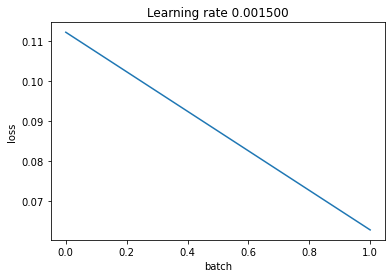

In [60]:
plt.plot(losses)
plt.ylabel('loss')
plt.xlabel('batch')
plt.title("Learning rate %f"%(learning_rate))
plt.show()

### Check accuracy

In [33]:
divisor = 900 # Set to 1 to run for all data

# Function that gets submatrix in dense format
def get_dense_submat(full_sparse_mat, start, end, ais=False):
    try:
        if ais == False:
            return torch.index_select(full_sparse_mat,0,torch.tensor(list(range(start, end)))).to_dense()
        else:
            raise("Not sure what's going on")
    except:
        return torch.index_select(full_sparse_mat,0,torch.tensor(list(range(start, end))))

    
    
    
# Okay all of this is junk im going to start over
# What I think I need:
#   - Get predictions for each patient
#   - Get the ais codes for each patient
#   - Compare those, then incr  
    
# Check accuracy on training & test to see how good our model
def check_accuracy(sparse_icd, sparse_ais, model):
    num_correct = 0
    num_samples = 0
    model.eval()
    # Keep track of where we are
    current_row = 0
    end = 1983
    # Transfer to GPU
    sparse_icd, sparse_ais = sparse_icd.to(device), sparse_ais.to(device)
    with torch.no_grad():
        # While current row isn't higher than the desired length
        while not current_row >= (len(sparse_icd) / (divisor * batch_size)):
            # Get predictions
            scores = model(get_dense_submat(sparse_icd, current_row, end))
            _, predictions = scores.max(1)
            predictions = predictions.to(device)

            
            dense_pred = get_dense_submat(predictions, current_row, end)
            dense_ais = get_dense_submat(sparse_ais, current_row, end, ais=True)
            # For row in batch
            for row in range(current_row, end):
                print(dense_pred)
                print(dense_ais)
                # If prediction matches sparse ais, add another correct
                num_correct += (dense_pred[row] == 
                                dense_ais[row])
                num_samples += predictions.size(0)
                return 'done'
            current_row = end
            # If end is greater than the length we are trying to go to, just set end to that length
            if end >= (len(sparse_icd) / (divisor * batch_size)):
                end = (len(sparse_icd) / (divisor * batch_size))
            end += 1983

    model.train()
    return num_correct/num_samples

print(f"Accuracy on training set: ")
print(check_accuracy(sparse_icd_train, sparse_ais_train, model)*100)
print(f"Accuracy on test set: ")
print(check_accuracy(sparse_icd_test, sparse_ais_test, model)*100)

Accuracy on training set: 


RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cpu and cuda:0! (when checking argument for argument mat1 in method wrapper__addmm)